In [1]:
using DataFrames
using ExcelReaders
using Plots
using DataValues
using XLSX
using Statistics

In [2]:
data_matrix_ind_col1 = readxlsheet("/home/AD/faidy/JuliaStatsProject/data/raw/real_data/Données_EDF_240611/Colmatage/IND-COL-1.xls", "IND-COL-1")

1083×17 Matrix{Any}:
 "UNITE"  "SOUS_UNITE"  "CIRCUIT"   "NUMERO"  …  "TUBISTE"  "CONSTITUTION"
 "U4"     "S1"          "C3"       1.27          "S"        "CONST2"
 "U4"     "S1"          "C3"       1.27          "S"        "CONST2"
 "U4"     "S1"          "C3"       1.27          "S"        "CONST2"
 "U4"     "S1"          "C3"       1.27          "S"        "CONST2"
 "U4"     "S1"          "C3"       1.27       …  "S"        "CONST2"
 "U4"     "S1"          "C3"       1.27          "S"        "CONST2"
 "U4"     "S1"          "C3"       1.27          "S"        "CONST2"
 "U4"     "S2"          "C1"       1.43          "V"        "CONST2"
 "U4"     "S2"          "C1"       1.43          "V"        "CONST2"
 ⋮                                            ⋱  ⋮          
 "U19"    "S3"          "C2"       2.56          "V"        "CONST3"
 "U19"    "S3"          "C2"       2.56       …  "V"        "CONST3"
 "U19"    "S3"          "C2"       2.56          "V"        "CONST3"
 "U19"    "S4" 

In [3]:
data_matrix_ind_col2 = readxlsheet("/home/AD/faidy/JuliaStatsProject/data/raw/real_data/Données_EDF_240611/Colmatage/IND-COL-2.xls", "IND-COL-2")

18722×17 Matrix{Any}:
 "UNITE"  "SOUS_UNITE"  "CIRCUIT"   "NUMERO"  …  "TUBISTE"  "CONSTITUTION"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4        …  "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 ⋮                                            ⋱  ⋮          
 "U19"    "S4"          "C3"       2.8           "V"        "CONST3"
 "U19"    "S4"          "C3"       2.8           "V"        "CONST3"
 "U19"    "S4"          "C3"       2.8        …  "V"        "CONST3"
 "U19"    "S4"

In [4]:
typeof(data_matrix_ind_col1)

Matrix{Any} (alias for Array{Any, 2})

In [5]:
isNA(x) = typeof(x) == DataValue{Union{}}
valeurs = replace( x -> isNA(x) ? missing : x, data_matrix_ind_col1)

data_matrix_ind_col1 = replace( x -> isNA(x) ? missing : x, data_matrix_ind_col1)
data_matrix_ind_col2 = replace( x -> isNA(x) ? missing : x, data_matrix_ind_col2)

18722×17 Matrix{Any}:
 "UNITE"  "SOUS_UNITE"  "CIRCUIT"   "NUMERO"  …  "TUBISTE"  "CONSTITUTION"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4        …  "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 "U1"     "S1"          "C1"       1.4           "W"        "CONST2"
 ⋮                                            ⋱  ⋮          
 "U19"    "S4"          "C3"       2.8           "V"        "CONST3"
 "U19"    "S4"          "C3"       2.8           "V"        "CONST3"
 "U19"    "S4"          "C3"       2.8        …  "V"        "CONST3"
 "U19"    "S4"

In [6]:
function MatrixToDataFrame(mat)
    DF_mat = DataFrame(
        mat[2:end, 1:end],
        string.(mat[1, 1:end])
    )
    return DF_mat
end

MatrixToDataFrame (generic function with 1 method)

In [7]:
df1 = MatrixToDataFrame(data_matrix_ind_col1)


Row,UNITE,SOUS_UNITE,CIRCUIT,NUMERO,BR,HEURES_MAT,PE,AVANT_NET,APRES_NET,INFER,VALEUR,INCERTITUDE,TAUX_H,REFERENCE,ACIERISTE,TUBISTE,CONSTITUTION
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,U4,S1,C3,1.27,F,215612.0,E9,false,false,false,28.0,5.0,6.0,R12,S,S,CONST2
2,U4,S1,C3,1.27,F,224510.0,E9,true,false,false,30.0,5.0,missing,R12,S,S,CONST2
3,U4,S1,C3,1.27,F,237085.0,E9,false,false,true,15.0,missing,missing,R12,S,S,CONST2
4,U4,S1,C3,1.27,F,245389.0,E5,false,false,true,10.0,missing,missing,R12,S,S,CONST2
5,U4,S1,C3,1.27,F,245389.0,E6,false,false,false,missing,missing,missing,R12,S,S,CONST2
6,U4,S1,C3,1.27,F,245389.0,E1,false,false,false,missing,missing,missing,R12,S,S,CONST2
7,U4,S1,C3,1.27,F,245389.0,E9,false,false,true,15.0,missing,missing,R12,S,S,CONST2
8,U4,S2,C1,1.43,F,148255.0,E9,false,false,true,10.0,missing,missing,R12,HI,V,CONST2
9,U4,S2,C1,1.43,F,148255.0,E5,false,false,false,missing,missing,missing,R12,HI,V,CONST2


In [8]:
df2 = MatrixToDataFrame(data_matrix_ind_col2)

Row,UNITE,SOUS_UNITE,CIRCUIT,NUMERO,BR,HEURES_MAT,PE,AVANT_NET,APRES_NET,SONDE,INFER,VALEUR,INCERTITUDE,REFERENCE,ACIERISTE,TUBISTE,CONSTITUTION
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,U1,S1,C1,1.4,C,128388.0,E2,false,false,IND-COL-2,false,25.9,missing,R12,H,W,CONST2
2,U1,S1,C1,1.4,C,128388.0,E5,false,false,IND-COL-2,false,25.7,missing,R12,H,W,CONST2
3,U1,S1,C1,1.4,C,128388.0,E7,false,false,IND-COL-2,false,25.8,missing,R12,H,W,CONST2
4,U1,S1,C1,1.4,C,128388.0,E1,false,false,IND-COL-2,false,23.7,missing,R12,H,W,CONST2
5,U1,S1,C1,1.4,C,128388.0,E9,false,false,IND-COL-2,false,20.7,missing,R12,H,W,CONST2
6,U1,S1,C1,1.4,C,128388.0,E3,false,false,IND-COL-2,false,27.8,missing,R12,H,W,CONST2
7,U1,S1,C1,1.4,C,128388.0,E4,false,false,IND-COL-2,false,26.6,missing,R12,H,W,CONST2
8,U1,S1,C1,1.4,C,128388.0,E6,false,false,IND-COL-2,false,25.9,missing,R12,H,W,CONST2
9,U1,S1,C1,1.4,C,128388.0,E8,false,false,IND-COL-2,false,19.5,missing,R12,H,W,CONST2


In [9]:
typeof(df1)

DataFrame

In [10]:
df1.VALEUR

1082-element Vector{Any}:
 28.0
 30.0
 15.0
 10.0
   missing
   missing
 15.0
 10.0
   missing
   missing
  ⋮
   missing
 15.0
 15.0
 10.0
 14.0
   missing
   missing
 15.0
 25.0

In [11]:
df1 = dropmissing(df1, :VALEUR)
df2 = dropmissing(df2, :VALEUR)

Row,UNITE,SOUS_UNITE,CIRCUIT,NUMERO,BR,HEURES_MAT,PE,AVANT_NET,APRES_NET,SONDE,INFER,VALEUR,INCERTITUDE,REFERENCE,ACIERISTE,TUBISTE,CONSTITUTION
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,U1,S1,C1,1.4,C,128388.0,E2,false,false,IND-COL-2,false,25.9,missing,R12,H,W,CONST2
2,U1,S1,C1,1.4,C,128388.0,E5,false,false,IND-COL-2,false,25.7,missing,R12,H,W,CONST2
3,U1,S1,C1,1.4,C,128388.0,E7,false,false,IND-COL-2,false,25.8,missing,R12,H,W,CONST2
4,U1,S1,C1,1.4,C,128388.0,E1,false,false,IND-COL-2,false,23.7,missing,R12,H,W,CONST2
5,U1,S1,C1,1.4,C,128388.0,E9,false,false,IND-COL-2,false,20.7,missing,R12,H,W,CONST2
6,U1,S1,C1,1.4,C,128388.0,E3,false,false,IND-COL-2,false,27.8,missing,R12,H,W,CONST2
7,U1,S1,C1,1.4,C,128388.0,E4,false,false,IND-COL-2,false,26.6,missing,R12,H,W,CONST2
8,U1,S1,C1,1.4,C,128388.0,E6,false,false,IND-COL-2,false,25.9,missing,R12,H,W,CONST2
9,U1,S1,C1,1.4,C,128388.0,E8,false,false,IND-COL-2,false,19.5,missing,R12,H,W,CONST2


In [12]:
unites = unique(df1.UNITE)
sizesE9 = []
sizesE8 = []
for unite in unites
    unite_data = df1[df1.UNITE .== unite,:]
    sous_unites = unique(unite_data.SOUS_UNITE)
    for sous_unite in sous_unites
        sous_unite_data = unite_data[unite_data.SOUS_UNITE .== sous_unite,:]
        circuits = unique(sous_unite_data.CIRCUIT)
        for circuit in circuits
            circuit_data = filter(row -> row.PE .== "E9" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit,:])
            p = plot(circuit_data[circuit_data.PE .== "E9",:].HEURES_MAT, circuit_data[circuit_data.PE .== "E9",:].VALEUR, seriestype=:scatter, xlabel="HEURES_MAT", ylabel="VALEUR", label="IND-COL-1", legend=:topright)

            circuit_data_E8 = filter(row -> row.PE .== "E8" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit,:])
            # # Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
            # directory = "/home/AD/faidy/JuliaStatsProject/plots"

            # # Combiner le chemin de répertoire et le nom du fichier
            # filename = joinpath(directory, "IND-COL1 $unite $sous_unite $circuit.png")

            # # Sauvegarder le graphique dans le fichier spécifié
            # savefig(p, filename)
            append!(sizesE9, size(circuit_data.HEURES_MAT)[1])
            append!(sizesE8, size(circuit_data_E8.HEURES_MAT)[1])
        end
    end
end


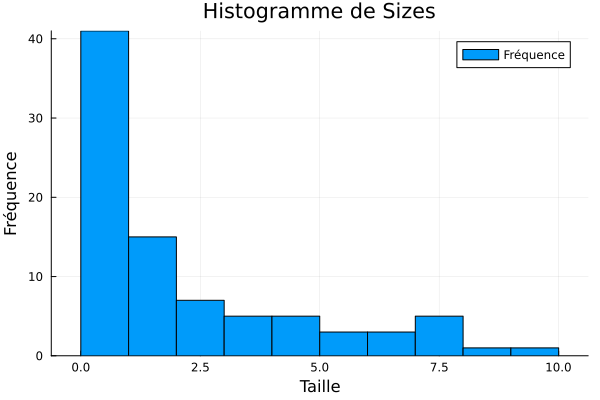

In [13]:

# Créer l'histogramme
histogram(sizesE9, bins=15, title="Histogramme de Sizes", xlabel="Taille", ylabel="Fréquence", label="Fréquence")

# Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
# directory = "/home/AD/faidy/JuliaStatsProject/plots"

# # Combiner le chemin de répertoire et le nom du fichier
# filename = joinpath(directory, "histogramme_sizes.png")

# Sauvegarder l'histogramme dans le fichier spécifié
# savefig(filename)

# println("Histogramme enregistré dans le fichier $filename")


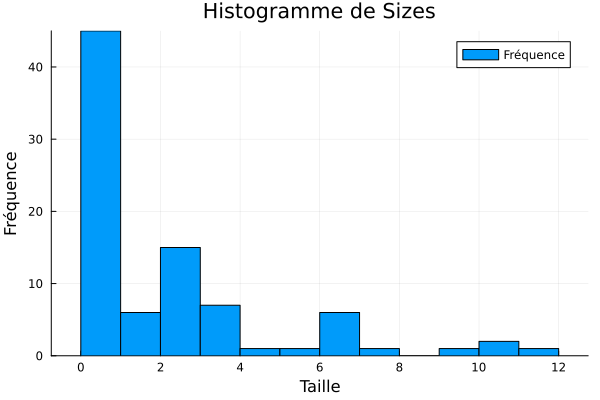

In [14]:
histogram(sizesE8, bins=15, title="Histogramme de Sizes", xlabel="Taille", ylabel="Fréquence", label="Fréquence")


In [15]:
unites = unique(df2.UNITE)
sizes2E9 = []
sizes2E8 = []
for unite in unites
    unite_data = df2[df2.UNITE .== unite,:]
    sous_unites = unique(unite_data.SOUS_UNITE)
    for sous_unite in sous_unites
        sous_unite_data = unite_data[unite_data.SOUS_UNITE .== sous_unite,:]
        circuits = unique(sous_unite_data.CIRCUIT)
        for circuit in circuits
            circuit_data = filter(row -> row.PE .== "E9" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit,:])
            p = plot(circuit_data[circuit_data.PE .== "E9",:].HEURES_MAT, circuit_data[circuit_data.PE .== "E9",:].VALEUR, seriestype=:scatter, xlabel="HEURES_MAT", ylabel="VALEUR", label="IND-COL-1", legend=:topright)
            
            circuit_data_E8 = filter(row -> row.PE .== "E8" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit,:])
            # # Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
            # directory = "/home/AD/faidy/JuliaStatsProject/plots"

            # # Combiner le chemin de répertoire et le nom du fichier
            # filename = joinpath(directory, "IND-COL-2 $unite $sous_unite $circuit.png")

            # # Sauvegarder le graphique dans le fichier spécifié
            # savefig(p, filename)
            append!(sizes2E9, size(circuit_data.HEURES_MAT)[1])
            append!(sizes2E8, size(circuit_data_E8.HEURES_MAT)[1])
        end
    end
end


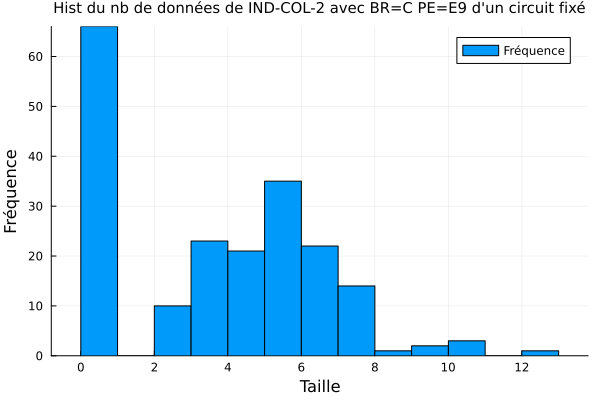

In [16]:
# Créer l'histogramme
histogram(sizes2E9, bins=14, title="Hist du nb de données de IND-COL-2 avec BR=C PE=E9 d'un circuit fixé", xlabel="Taille", ylabel="Fréquence", label="Fréquence", titlefontsize=10)


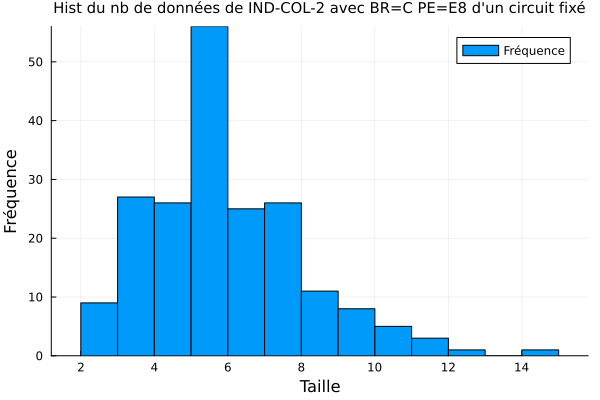

In [17]:
histogram(sizes2E8, bins=14, title="Hist du nb de données de IND-COL-2 avec BR=C PE=E8 d'un circuit fixé", xlabel="Taille", ylabel="Fréquence", label="Fréquence", titlefontsize=10)

In [18]:
df_one_two = vcat(df1, df2, cols = :union )

Row,UNITE,SOUS_UNITE,CIRCUIT,NUMERO,BR,HEURES_MAT,PE,AVANT_NET,APRES_NET,INFER,VALEUR,INCERTITUDE,TAUX_H,REFERENCE,ACIERISTE,TUBISTE,CONSTITUTION,SONDE
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,U4,S1,C3,1.27,F,215612.0,E9,false,false,false,28.0,5.0,6.0,R12,S,S,CONST2,missing
2,U4,S1,C3,1.27,F,224510.0,E9,true,false,false,30.0,5.0,missing,R12,S,S,CONST2,missing
3,U4,S1,C3,1.27,F,237085.0,E9,false,false,true,15.0,missing,missing,R12,S,S,CONST2,missing
4,U4,S1,C3,1.27,F,245389.0,E5,false,false,true,10.0,missing,missing,R12,S,S,CONST2,missing
5,U4,S1,C3,1.27,F,245389.0,E9,false,false,true,15.0,missing,missing,R12,S,S,CONST2,missing
6,U4,S2,C1,1.43,F,148255.0,E9,false,false,true,10.0,missing,missing,R12,HI,V,CONST2,missing
7,U4,S2,C1,1.43,F,158664.0,E1,false,false,true,10.0,missing,missing,R12,HI,V,CONST2,missing
8,U4,S2,C1,1.43,F,158664.0,E9,false,false,true,10.0,missing,missing,R12,HI,V,CONST2,missing
9,U4,S2,C1,1.43,F,179900.0,E1,false,false,true,10.0,missing,missing,R12,HI,V,CONST2,missing


In [19]:
df1 = nothing
df2 = nothing

In [20]:
dropmissing(df_one_two, :SONDE)
missing_rows = df_one_two[ismissing.(df_one_two.SONDE), :]

Row,UNITE,SOUS_UNITE,CIRCUIT,NUMERO,BR,HEURES_MAT,PE,AVANT_NET,APRES_NET,INFER,VALEUR,INCERTITUDE,TAUX_H,REFERENCE,ACIERISTE,TUBISTE,CONSTITUTION,SONDE
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,U4,S1,C3,1.27,F,215612.0,E9,false,false,false,28.0,5.0,6.0,R12,S,S,CONST2,missing
2,U4,S1,C3,1.27,F,224510.0,E9,true,false,false,30.0,5.0,missing,R12,S,S,CONST2,missing
3,U4,S1,C3,1.27,F,237085.0,E9,false,false,true,15.0,missing,missing,R12,S,S,CONST2,missing
4,U4,S1,C3,1.27,F,245389.0,E5,false,false,true,10.0,missing,missing,R12,S,S,CONST2,missing
5,U4,S1,C3,1.27,F,245389.0,E9,false,false,true,15.0,missing,missing,R12,S,S,CONST2,missing
6,U4,S2,C1,1.43,F,148255.0,E9,false,false,true,10.0,missing,missing,R12,HI,V,CONST2,missing
7,U4,S2,C1,1.43,F,158664.0,E1,false,false,true,10.0,missing,missing,R12,HI,V,CONST2,missing
8,U4,S2,C1,1.43,F,158664.0,E9,false,false,true,10.0,missing,missing,R12,HI,V,CONST2,missing
9,U4,S2,C1,1.43,F,179900.0,E1,false,false,true,10.0,missing,missing,R12,HI,V,CONST2,missing


In [21]:
nettoyages = readxlsheet("/home/AD/faidy/JuliaStatsProject/data/raw/real_data/Données_EDF_240611/Nettoyages/NETTOYAGES.xls", "NETTOYAGES")
df_nettoyages = MatrixToDataFrame(nettoyages)
df_nettoyages = df_nettoyages[:, [:UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO, :HEURES_MAT]]
df_nettoyages = rename!(df_nettoyages, :HEURES_MAT => :HEURES_NETT)

Row,UNITE,SOUS_UNITE,CIRCUIT,NUMERO,HEURES_NETT
,Any,Any,Any,Any,Any
1,U14,S1,C1,1.5,12110.0
2,U14,S1,C2,1.48,12110.0
3,U14,S1,C3,1.47,12110.0
4,U14,S1,C4,1.52,12110.0
5,U17,S2,C1,1.35,23613.0
6,U17,S2,C2,1.34,23613.0
7,U17,S2,C3,1.32,23613.0
8,U17,S2,C4,1.33,23613.0
9,U10,S2,C1,0.04,101049.0


In [22]:
unites = unique(df_one_two.UNITE)
sizes2 = []
for unite in unites
    unite_data = df_one_two[df_one_two.UNITE .== unite,:]
    sous_unites = unique(unite_data.SOUS_UNITE)
    for sous_unite in sous_unites
        sous_unite_data = unite_data[unite_data.SOUS_UNITE .== sous_unite,:]
        circuits = unique(sous_unite_data.CIRCUIT)
        for circuit in circuits
            circuit_data = filter(row -> row.PE .== "E9" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit,:])
            if isempty(circuit_data)
                circuit_data = filter(row -> row.PE .== "E8" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit,:])
            end
            ind_col_1 = circuit_data[ismissing.(circuit_data.SONDE),:]
            sort!(ind_col_1, :HEURES_MAT)
            ind_col_2 = circuit_data[.!ismissing.(circuit_data.SONDE),:]
            sort!(ind_col_2, :HEURES_MAT)

            p = plot(ind_col_1.HEURES_MAT, ind_col_1.VALEUR, xlabel="HEURES_MAT", ylabel="VALEUR", label="IND-COL-1", legend=:topright, markershape=:circle, 
                markercolor=:blue, linestyle=:dash, title = "Évolution de IND-COL-1 et IND-COL-2 sur le(s) GV de $unite-$sous_unite-$circuit", titlefont = 10)
            plot!(p, ind_col_2.HEURES_MAT, ind_col_2.VALEUR, xlabel="HEURES_MAT", ylabel="VALEUR", label="IND-COL-2", legend=:topright,  markershape=:diamond, markercolor=:red, linestyle=:dash)
            # Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
            heures_nettoyages = filter(raw -> raw.UNITE .== unite && raw.SOUS_UNITE .== sous_unite && raw.CIRCUIT .== circuit, df_nettoyages)
            vline!(p, heures_nettoyages.HEURES_NETT, linestyle=:dot, color=:black, linewidth=1.5, label=false)

            directory = "/home/AD/faidy/JuliaStatsProject/plots/IND-COL-1-2"

            # Combiner le chemin de répertoire et le nom du fichier
            filename = joinpath(directory, "IND-COL-1&2 $unite $sous_unite $circuit.png")

            # Sauvegarder le graphique dans le fichier spécifié
            savefig(p, filename)
            append!(sizes2, size(circuit_data.HEURES_MAT)[1])
        end
    end
end



In [23]:
df_one_two.AVANT_NET[2]

true

In [44]:
unites = unique(df_one_two.UNITE)
sizes2 = []
for unite in unites
    unite_data = df_one_two[df_one_two.UNITE .== unite,:]
    sous_unites = unique(unite_data.SOUS_UNITE)
    for sous_unite in sous_unites
        sous_unite_data = unite_data[unite_data.SOUS_UNITE .== sous_unite,:]
        circuits = unique(sous_unite_data.CIRCUIT)
        for circuit in circuits
            circuit_data = filter(row -> row.PE .== "E9" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit,:])
            if isempty(circuit_data)
                circuit_data = filter(row -> row.PE .== "E8" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit,:])
            end
            ind_col_1 = circuit_data[ismissing.(circuit_data.SONDE),:]
            sort!(ind_col_1, :HEURES_MAT)
            ind_col_2 = circuit_data[.!ismissing.(circuit_data.SONDE),:]
            sort!(ind_col_2, :HEURES_MAT)

            heures_nettoyages = filter(raw -> raw.UNITE .== unite && raw.SOUS_UNITE .== sous_unite && raw.CIRCUIT .== circuit, df_nettoyages)
            
            if !isempty(heures_nettoyages)
                nettoyage_times = heures_nettoyages.HEURES_NETT

                has_points_between_nettoyages_1 = true
                for i in 1:length(nettoyage_times)-1
                    if !any((ind_col_1.HEURES_MAT .> nettoyage_times[i]) .& (ind_col_1.HEURES_MAT .< nettoyage_times[i+1]))
                        has_points_between_nettoyages_1 = false
                        break
                    end
                end
                
                has_points_between_nettoyages_2 = true
                for i in 1:length(nettoyage_times)-1
                    if !any((ind_col_2.HEURES_MAT .> nettoyage_times[i]) .& (ind_col_2.HEURES_MAT .< nettoyage_times[i+1]))
                        has_points_between_nettoyages_2 = false
                        break
                    end
                end

                if has_points_between_nettoyages_1 || has_points_between_nettoyages_2
                    # p = plot(ind_col_1.HEURES_MAT, ind_col_1.VALEUR, xlabel="HEURES_MAT", ylabel="VALEUR", label="IND-COL-1", markershape=:circle, 
                    #     markercolor=:blue, linestyle=:dash, title = "$has_points_between_nettoyages_1 || $has_points_between_nettoyages_2", titlefont = 10)
                    # plot!(p, ind_col_2.HEURES_MAT, ind_col_2.VALEUR, xlabel="HEURES_MAT", ylabel="VALEUR", label="IND-COL-2", markershape=:diamond, markercolor=:red, linestyle=:dash)
                    # # Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
                    # vline!(p, nettoyage_times, linestyle=:dot, color=:black, linewidth=1.5, label=false)

                    # directory = "/home/AD/faidy/JuliaStatsProject/plots/IND-COL-1-2"

                    # # Combiner le chemin de répertoire et le nom du fichier
                    # filename = joinpath(directory, "IND-COL-1&2 $unite $sous_unite $circuit.png")

                    # # Sauvegarder le graphique dans le fichier spécifié
                    # savefig(p, filename)

                    p = plot(xlabel="HEURES_MAT", ylabel="VALEUR", title = "Évolution de IND-COL-1 et IND-COL-2 sur le(s) GV de $unite-$sous_unite-$circuit", titlefont = 10)
                    
                    # Trace IND-COL-1 segments conditionally
                    for i in 1:length(ind_col_1.HEURES_MAT)-1
                        if !(ind_col_1.AVANT_NET[i] || ind_col_1.APRES_NET[i+1])
                            plot!(p, ind_col_1.HEURES_MAT[i:i+1], ind_col_1.VALEUR[i:i+1], label=false, color=:blue, linestyle=:dash)
                        end
                    end
                    
                    # Trace IND-COL-2 segments conditionally
                    for i in 1:length(ind_col_2.HEURES_MAT)-1
                        if !(ind_col_2.AVANT_NET[i] || ind_col_2.APRES_NET[i+1])
                            plot!(p, ind_col_2.HEURES_MAT[i:i+1], ind_col_2.VALEUR[i:i+1], label=false, color=:red, linestyle=:dash)
                        end
                    end
                    
                    # Trace les points
                    scatter!(p, ind_col_1.HEURES_MAT, ind_col_1.VALEUR, label="IND-COL-1", markershape=:circle, markercolor=:blue)
                    scatter!(p, ind_col_2.HEURES_MAT, ind_col_2.VALEUR, label="IND-COL-2", markershape=:diamond, markercolor=:red)

                    # Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
                    vline!(p, nettoyage_times, linestyle=:dot, color=:black, linewidth=1.5, label=false)

                    directory = "/home/AD/faidy/JuliaStatsProject/plots/IND-COL-1-2"

                    # Combiner le chemin de répertoire et le nom du fichier
                    filename = joinpath(directory, "IND-COL-1&2 $unite $sous_unite $circuit.png")

                    # Sauvegarder le graphique dans le fichier spécifié
                    savefig(p, filename)

                    append!(sizes2, size(circuit_data.HEURES_MAT)[1])
                end
            end
        end
    end
end



In [25]:
function IND_COL_3_and_EncMatToDataFrame(mat)
    # Extraire les noms des colonnes
    column_names = [mat[1,1],"$(mat[2,3])_ENC", "$(mat[2,4])_ENC", "$(mat[2,5])_ENC", "$(mat[2,6])_ENC", "$(mat[2,15])_IND_COL_3", "$(mat[2,16])_IND_COL_3", "$(mat[2,17])_IND_COL_3", "$(mat[2,18])_IND_COL_3"]

    # Créer un DataFrame à partir des données extraites
    df = DataFrame()

    # Ajouter les données au DataFrame
    df[!, column_names[1]] = mat[2:end,1]
    df[!, column_names[2]] = mat[2:end,3]
    df[!, column_names[3]] = mat[2:end,4]
    df[!, column_names[4]] = mat[2:end,5]
    df[!, column_names[5]] = mat[2:end,6]

    df[!, column_names[6]] = mat[2:end,15]
    df[!, column_names[7]] = mat[2:end,16]
    df[!, column_names[8]] = mat[2:end,17]
    df[!, column_names[9]] = mat[2:end,18]

    return df
end


IND_COL_3_and_EncMatToDataFrame (generic function with 1 method)

In [26]:
using XLSX

# Spécifiez le chemin complet de votre répertoire
directory = "/home/AD/faidy/JuliaStatsProject/data/raw/real_data/Données_EDF_240611/Encrassement"

# Utilisez readdir() pour obtenir les noms des fichiers et des sous-répertoires
files = readdir(directory)

# Filtrer les fichiers pour ne garder que ceux qui ont l'extension .xlsx
xlsx_files = filter(file -> endswith(file, ".xlsx"), files)
xlsx_files = [file for file in xlsx_files if file != "~\$PERFOS_U2S4_3,48-3,47-3,49.xlsx" && file != "~\$PERFOS_U19S2_2,45-2,43-2,44.xlsx"]
# Initialiser un dictionnaire vide pour stocker les DataFrames
dict_df_enc = Dict{String, DataFrame}()

# Lire les fichiers .xlsx et afficher les premières lignes
for file in xlsx_files
    try
        # Lire la première feuille du fichier .xlsx
        df = IND_COL_3_and_EncMatToDataFrame(XLSX.readdata("$directory/$file", "Feuil1", "A1:V144"))
        dict_df_enc[file] = dropmissing(df, :HEURES_MAT)

    catch e
        display("Erreur lors de la lecture du fichier $file: $e")
    end
end


In [27]:
length(dict_df_enc)
size(files)

(58,)

In [28]:
file = "/home/AD/faidy/JuliaStatsProject/plots/ENC IND-ENC_U3S4_2,61-2,6-2,59.xlsx.png"

# Fonction pour extraire les motifs "Ux" et "Sy"
function extract_UxSy(text::String)
    # Initialiser les variables de sortie
    Ux = ""
    Sy = ""
    
    # Trouver le premier motif "Ux"
    start_idx = findfirst(isequal('U'), text)
    if start_idx !== nothing
        end_idx = start_idx + 1
        while end_idx <= length(text) && isdigit(text[end_idx])
            end_idx += 1
        end
        Ux = text[start_idx:end_idx-1]
    end
    
    # Trouver le motif "Sy" après "Ux"
    if !isempty(Ux)
        start_idx = findnext(isequal('S'), text, end_idx)
        if start_idx !== nothing
            end_idx = start_idx + 1
            while end_idx <= length(text) && isdigit(text[end_idx])
                end_idx += 1
            end
            Sy = text[start_idx:end_idx-1]
        end
    end
    
    return Ux, Sy
end

# Appel de la fonction pour extraire "Ux" et "Sy" de 'file'
Ux, Sy = extract_UxSy(file)

# Affichage des résultats
println("Premier motif Ux trouvé : ", Ux)
println("Premier motif Sy trouvé : ", Sy)



Premier motif Ux trouvé : U3
Premier motif Sy trouvé : S4


In [29]:
for file in xlsx_files
    p = plot(dict_df_enc[file].HEURES_MAT, dict_df_enc[file].C1_ENC, xlabel="HEURES_MAT", ylabel="VALEUR", label="C1", legend=:topright, markershape=:circle, markercolor=:blue, linestyle=:dash)
    plot!(p, dict_df_enc[file].HEURES_MAT, dict_df_enc[file].C2_ENC, xlabel="HEURES_MAT", ylabel="VALEUR", label="C2", legend=:topright,  markershape=:diamond, markercolor=:red, linestyle=:dash)
    plot!(p, dict_df_enc[file].HEURES_MAT, dict_df_enc[file].C3_ENC, xlabel="HEURES_MAT", ylabel="VALEUR", label="C3", legend=:topright,  markershape=:diamond, markercolor=:red, linestyle=:dash)

    # Nombre de lignes verticales à ajouter
    num_lines = 30

    # Positions des lignes verticales régulièrement espacées
    vertical_lines_positions = range(minimum(dict_df_enc[file].HEURES_MAT), stop=maximum(dict_df_enc[file].HEURES_MAT), length=num_lines)

    # Ajouter les lignes verticales au plot
    for pos in vertical_lines_positions
        vline!(p, [pos], linestyle=:dot, color=:lightgray, linewidth=1.5, label=false)
    end
    
    unite, sous_unite = extract_UxSy(file)
    
    heures_nettoyages = filter(raw -> raw.UNITE .== unite && raw.SOUS_UNITE .== sous_unite, df_nettoyages)
    vline!(p, heures_nettoyages.HEURES_NETT, linestyle=:dot, color=:black, linewidth=1.5, label=false)


    # Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
    directory = "/home/AD/faidy/JuliaStatsProject/plots/ENC"

    # Combiner le chemin de répertoire et le nom du fichier
    filename = joinpath(directory, "ENC $file.png")

    # Sauvegarder le graphique dans le fichier spécifié
    savefig(p, filename)
end

In [30]:
for file in xlsx_files
    p = plot(dict_df_enc[file].HEURES_MAT, dict_df_enc[file].C1_IND_COL_3, xlabel="HEURES_MAT", ylabel="VALEUR", label="C1", legend=:topright, markershape=:circle, markercolor=:blue, linestyle=:dash)
    plot!(p, dict_df_enc[file].HEURES_MAT, dict_df_enc[file].C2_IND_COL_3, xlabel="HEURES_MAT", ylabel="VALEUR", label="C2", legend=:topright,  markershape=:diamond, markercolor=:red, linestyle=:dash)
    plot!(p, dict_df_enc[file].HEURES_MAT, dict_df_enc[file].C3_IND_COL_3, xlabel="HEURES_MAT", ylabel="VALEUR", label="C3", legend=:topright,  markershape=:diamond, markercolor=:red, linestyle=:dash)

    # Nombre de lignes verticales à ajouter
    num_lines = 30

    # Positions des lignes verticales régulièrement espacées
    vertical_lines_positions = range(minimum(dict_df_enc[file].HEURES_MAT), stop=maximum(dict_df_enc[file].HEURES_MAT), length=num_lines)

    # Ajouter les lignes verticales au plot
    for pos in vertical_lines_positions
        vline!(p, [pos], linestyle=:dot, color=:lightgray, linewidth=1.5, label=false)
    end

    unite, sous_unite = extract_UxSy(file)
    
    heures_nettoyages = filter(raw -> raw.UNITE .== unite && raw.SOUS_UNITE .== sous_unite, df_nettoyages)
    vline!(p, heures_nettoyages.HEURES_NETT, linestyle=:dot, color=:black, linewidth=1.5, label=false)


    # Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
    directory = "/home/AD/faidy/JuliaStatsProject/plots/IND_COL_3"

    # Combiner le chemin de répertoire et le nom du fichier
    filename = joinpath(directory, "IND_COL_3 $file.png")

    # Sauvegarder le graphique dans le fichier spécifié
    savefig(p, filename)
end

In [31]:
nettoyages = readxlsheet("/home/AD/faidy/JuliaStatsProject/data/raw/real_data/Données_EDF_240611/Nettoyages/NETTOYAGES.xls", "NETTOYAGES")

188×22 Matrix{Any}:
 "UNITE"  "SOUS_UNITE"  "CIRCUIT"  "REFERENCE"  …  "FAMILLE PROCEDE"
 "U14"    "S1"          "C1"       "R12"           #NA
 "U14"    "S1"          "C2"       "R12"           #NA
 "U14"    "S1"          "C3"       "R12"           #NA
 "U14"    "S1"          "C4"       "R12"           #NA
 "U17"    "S2"          "C1"       "R12"        …  #NA
 "U17"    "S2"          "C2"       "R12"           #NA
 "U17"    "S2"          "C3"       "R12"           #NA
 "U17"    "S2"          "C4"       "R12"           #NA
 "U10"    "S2"          "C1"       "R3"            #NA
 ⋮                                              ⋱  
 "U4"     "S4"          "C3"       "R12"           "FAM2"
 "U4"     "S4"          "C4"       "R12"        …  "FAM2"
 "U14"    "S1"          "C1"       "R12"           "FAM2"
 "U14"    "S1"          "C2"       "R12"           "FAM2"
 "U14"    "S1"          "C3"       "R12"           "FAM2"
 "U14"    "S1"          "C4"       "R12"           "FAM2"
 "U3"     "S3"  

In [32]:
df_nettoyages = MatrixToDataFrame(nettoyages)

Row,UNITE,SOUS_UNITE,CIRCUIT,REFERENCE,NUMERO,HEURES_MAT,Plaque à tube - curatif,Plaque à tube - préventif,PE_CURATIF,PE_PREVENTIF,INTERVENANT,ZONE,PROCEDE,BOUE_KG,CUIVRE_KG,EFFICACITE_DECOLMATAGE_ESTIMEE_MIN,EFFICACITE_DECOLMATAGE_ESTIMEE_MAX,ACIERISTE,TUBISTE,CONSTITUTION,INTERET ANALYSE,FAMILLE PROCEDE
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,U14,S1,C1,R12,1.5,12110.0,true,false,true,false,I3,GV Entier,PROC5,1827.0,3.0,#NA,#NA,I,V,CONST2,HORS SCOPE,#NA
2,U14,S1,C2,R12,1.48,12110.0,true,false,true,false,I3,GV Entier,PROC5,1565.0,6.0,#NA,#NA,H,W,CONST2,HORS SCOPE,#NA
3,U14,S1,C3,R12,1.47,12110.0,true,false,true,false,I3,GV Entier,PROC5,1882.0,6.0,#NA,#NA,I,V,CONST2,HORS SCOPE,#NA
4,U14,S1,C4,R12,1.52,12110.0,true,false,true,false,I3,GV Entier,PROC5,1788.0,1.0,#NA,#NA,I,V,CONST2,HORS SCOPE,#NA
5,U17,S2,C1,R12,1.35,23613.0,true,false,false,false,I3,GV Partiel,PROC5,348.0,1.0,#NA,#NA,I,V,CONST2,HORS SCOPE,#NA
6,U17,S2,C2,R12,1.34,23613.0,true,false,false,false,I3,GV Partiel,PROC5,334.0,2.0,#NA,#NA,I,V,CONST2,HORS SCOPE,#NA
7,U17,S2,C3,R12,1.32,23613.0,true,false,false,false,I3,GV Partiel,PROC5,285.0,3.0,#NA,#NA,H,W,CONST2,HORS SCOPE,#NA
8,U17,S2,C4,R12,1.33,23613.0,true,false,false,false,I3,GV Partiel,PROC5,259.0,2.0,#NA,#NA,S,S,CONST2,HORS SCOPE,#NA
9,U10,S2,C1,R3,0.04,101049.0,true,false,true,false,I3,GV Entier,PROC5,3028.0,155.0,#NA,#NA,S,S,CONST1,HORS SCOPE,#NA


In [33]:
df_nettoyages = df_nettoyages[:, [:UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO, :HEURES_MAT]]
df_nettoyages = rename!(df_nettoyages, :HEURES_MAT => :HEURES_NETT)

Row,UNITE,SOUS_UNITE,CIRCUIT,NUMERO,HEURES_NETT
,Any,Any,Any,Any,Any
1,U14,S1,C1,1.5,12110.0
2,U14,S1,C2,1.48,12110.0
3,U14,S1,C3,1.47,12110.0
4,U14,S1,C4,1.52,12110.0
5,U17,S2,C1,1.35,23613.0
6,U17,S2,C2,1.34,23613.0
7,U17,S2,C3,1.32,23613.0
8,U17,S2,C4,1.33,23613.0
9,U10,S2,C1,0.04,101049.0


In [34]:
# df_one_two_with_nett = leftjoin(df_one_two[:, [:UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO, :HEURES_MAT]], df_nettoyages, on = [:UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO] )


In [35]:
unites = unique(df_one_two.UNITE)
sizes_between_nett_col1 = []
sizes_between_nett_col2 = []
sizes_on_nett_col1 = []
sizes_on_nett_col2 = []
for unite in unites
    unite_data = df_one_two[df_one_two.UNITE .== unite,:]
    sous_unites = unique(unite_data.SOUS_UNITE)
    for sous_unite in sous_unites
        sous_unite_data = unite_data[unite_data.SOUS_UNITE .== sous_unite,:]
        circuits = unique(sous_unite_data.CIRCUIT)
        for circuit in circuits
            
            heures_nettoyages = filter(raw -> raw.UNITE .== unite && raw.SOUS_UNITE .== sous_unite && raw.CIRCUIT .== circuit, df_nettoyages)
            
            if !isempty(heures_nettoyages)
                circuit_data = filter(row -> row.PE .== "E9" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit,:])
                sort!(heures_nettoyages, :HEURES_NETT)

                if !isempty(circuit_data)
                    ind_col_1 = circuit_data[ismissing.(circuit_data.SONDE),:]
                    ind_col_2 = circuit_data[.!ismissing.(circuit_data.SONDE),:]
                    if !isempty(ind_col_1)    
                        # Compter les points de `circuit_data` dont `HEURES_MAT` est dans l'intervalle [start_time, end_time)
                        for i in 1:(nrow(heures_nettoyages) - 1)
                            start_time = heures_nettoyages.HEURES_NETT[i]
                            end_time = heures_nettoyages.HEURES_NETT[i + 1]
                            
                            count_points1 = count(row -> start_time < row < end_time, ind_col_1.HEURES_MAT)
                            count_points3 = count(row -> start_time == row , ind_col_1.HEURES_MAT)
                            # Ajouter le nombre de points à `points_counts`
                            push!(sizes_between_nett_col1, count_points1)
                            push!(sizes_on_nett_col1, count_points3)
                        end
                    end
                    if !isempty(ind_col_2)
                        for i in 1:(nrow(heures_nettoyages) - 1)
                            start_time = heures_nettoyages.HEURES_NETT[i]
                            end_time = heures_nettoyages.HEURES_NETT[i + 1]
                            
                            count_points2 = count(row -> start_time < row < end_time, ind_col_2.HEURES_MAT)
                            count_points3 = count(row -> start_time == row , ind_col_2.HEURES_MAT)
                            # Ajouter le nombre de points à `points_counts`
                            push!(sizes_between_nett_col2, count_points2)
                            push!(sizes_on_nett_col2, count_points3)
                        end
                    end
                else
                    circuit_data = filter(row -> row.PE .== "E8" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit,:])
                    ind_col_1 = circuit_data[ismissing.(circuit_data.SONDE),:]
                    ind_col_2 = circuit_data[.!ismissing.(circuit_data.SONDE),:]
                    
                    if !isempty(ind_col_1)    
                        # Compter les points de `circuit_data` dont `HEURES_MAT` est dans l'intervalle [start_time, end_time)
                        for i in 1:(nrow(heures_nettoyages) - 1)
                            start_time = heures_nettoyages.HEURES_NETT[i]
                            end_time = heures_nettoyages.HEURES_NETT[i + 1]
                            
                            count_points1 = count(row -> start_time < row < end_time, ind_col_1.HEURES_MAT)
                            count_points3 = count(row -> start_time == row , ind_col_1.HEURES_MAT)
                            # Ajouter le nombre de points à `points_counts`
                            push!(sizes_between_nett_col1, count_points1)
                            push!(sizes_on_nett_col1, count_points3)
                        end
                    end
                    if !isempty(ind_col_2)
                        for i in 1:(nrow(heures_nettoyages) - 1)
                            start_time = heures_nettoyages.HEURES_NETT[i]
                            end_time = heures_nettoyages.HEURES_NETT[i + 1]
                            
                            count_points2 = count(row -> start_time < row < end_time, ind_col_2.HEURES_MAT)
                            count_points3 = count(row -> start_time == row , ind_col_2.HEURES_MAT)
                            # Ajouter le nombre de points à `points_counts`
                            push!(sizes_between_nett_col2, count_points2)
                            push!(sizes_on_nett_col2, count_points3)
                        end
                    end
                end
            end
        end
    end
end



In [36]:
heures_nettoyages = filter(raw -> raw.UNITE .== "U4" && raw.SOUS_UNITE .== "S2" && raw.CIRCUIT .== "C3", df_nettoyages)
collect(1:0)

Int64[]

In [37]:
length(sizes_between_nett_col1)

52

In [38]:
length(sizes_between_nett_col2)

81

In [39]:
length(sizes_on_nett_col1)

52

In [47]:
histogram(sizes_between_nett_col1, bins=7, title="", xlabel="Taille", ylabel="Fréquence", label="Fréquence", titlefontsize=10)


UndefVarError: UndefVarError: `barplot` not defined

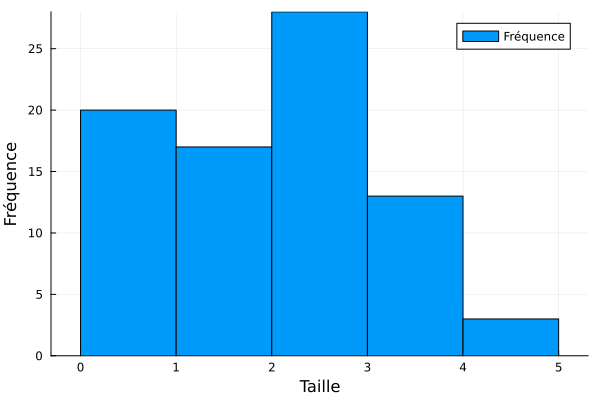

In [48]:
histogram(sizes_between_nett_col2, bins=6, title="", xlabel="Taille", ylabel="Fréquence", label="Fréquence", titlefontsize=10)



0.23076923076923078

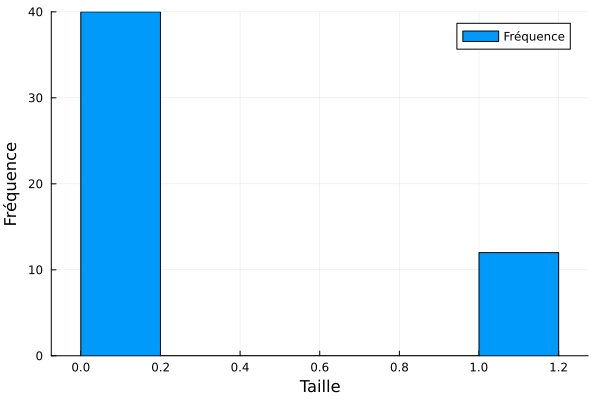

In [42]:
average_frequency = mean(sizes_on_nett_col1)
display(average_frequency)
histogram(sizes_on_nett_col1, bins=6, title="", xlabel="Taille", ylabel="Fréquence", label="Fréquence", titlefontsize=10)

0.6296296296296297

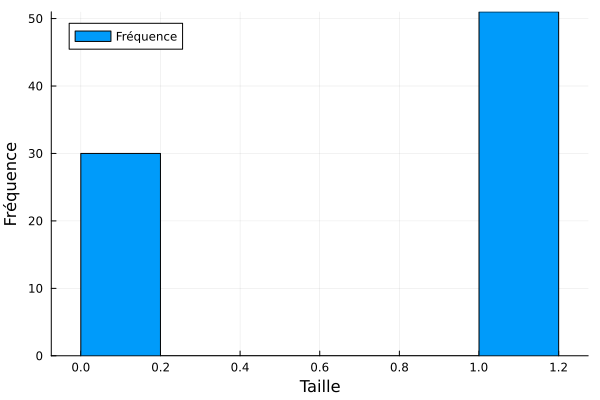

In [43]:
average_frequency = mean(sizes_on_nett_col2)
display(average_frequency)
histogram(sizes_on_nett_col2, bins=6, title="", xlabel="Taille", ylabel="Fréquence", label="Fréquence", titlefontsize=10)
